# Forecast of Products by store
Oct 9th 2022

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime, timedelta
from tqdm import tqdm
# Prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [2]:
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plotsize = (17, 5)
# Pandas config
pd.options.display.float_format= '{:,.4f}'.format

# 1) Input data

In [3]:
data_path = "../data/"
data_di = {}

for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        print(path)
        name = path.split('/')[-1].split('.')[0]
        try:
            data_di[name] = pd.read_csv(path, parse_dates=['date'])
        except:
            data_di[name] = pd.read_csv(path)
        
        # Rename columns to prophet standards
        if 'sales' in data_di[name].columns:
            data_di[name] = data_di[name].rename(columns={'sales': 'y'})
        if 'date' in data_di[name].columns:
            data_di[name] = data_di[name].rename(columns={'date': 'ds'})

../data/processed_dfs/proc_holidays_events.csv
../data/processed_dfs/holidays_prophet.csv
../data/processed_dfs/df_sales.csv
../data/raw_data/holidays_events.csv
../data/raw_data/test.csv
../data/raw_data/stores.csv
../data/raw_data/oil.csv
../data/raw_data/train.csv
../data/raw_data/transactions.csv
../data/raw_data/sample_submission.csv


In [4]:
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
    This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).
    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])
        
def rmsle(y_hat, y):
    """Compute Root Mean Squared Logarithmic Error"""
    metric = np.sqrt(sum((np.array(list(map(lambda x : np.log(x + 1), y_hat)))
                         - np.array(list(map(lambda x : np.log(x + 1), y))))**2)/len(y))
                
    return round(metric, 4)

In [5]:
data_di['train'].head(5)

id         ds  store_nbr      family      y  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE 0.0000            0
1   1 2013-01-01          1   BABY CARE 0.0000            0
2   2 2013-01-01          1      BEAUTY 0.0000            0
3   3 2013-01-01          1   BEVERAGES 0.0000            0
4   4 2013-01-01          1       BOOKS 0.0000            0

In [6]:
data_di['test'].head(5)

id         ds  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0

In [7]:
print("Number of Time Series (train):")
unique_keys_train = set(zip(data_di['train'].store_nbr, data_di['train'].family))
print(len(unique_keys_train))

print("Number of Time Series (test):")
unique_keys_test = set(zip(data_di['test'].store_nbr, data_di['test'].family))
print(len(unique_keys_test))

print("Keys in the test set that are not in the train set:")
unique_keys_test - unique_keys_train

Number of Time Series (train):
1782
Number of Time Series (test):
1782
Keys in the test set that are not in the train set:


set()

In [8]:
missing_ds_df = data_di['train'].groupby(['store_nbr', 'family']).resample('D', on='ds')['y'] \
        .first().loc[lambda x: x.isna()].index.to_frame(index=False)

missing_ds_df

store_nbr                      family         ds
0             1                  AUTOMOTIVE 2013-12-25
1             1                  AUTOMOTIVE 2014-12-25
2             1                  AUTOMOTIVE 2015-12-25
3             1                  AUTOMOTIVE 2016-12-25
4             1                   BABY CARE 2013-12-25
...         ...                         ...        ...
7123         54  SCHOOL AND OFFICE SUPPLIES 2016-12-25
7124         54                     SEAFOOD 2013-12-25
7125         54                     SEAFOOD 2014-12-25
7126         54                     SEAFOOD 2015-12-25
7127         54                     SEAFOOD 2016-12-25

[7128 rows x 3 columns]

In [9]:
missing_ds_df.ds.unique()

array(['2013-12-25T00:00:00.000000000', '2014-12-25T00:00:00.000000000',
       '2015-12-25T00:00:00.000000000', '2016-12-25T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [10]:
def plot_ts(key):
    fig, ax = plt.subplots(figsize=(20, 5))
    ts = data_di['train'][(data_di['train'].store_nbr == key[0]) & (data_di['train'].family == key[1])]
    plt.plot(ts.ds, ts.onpromotion*np.median(ts.y), label='promotion')
    plt.plot(ts.ds, ts.y, label='y')
    plt.title("Store: " + str(key[0]) + ", Family: " + key[1])
    plt.legend()
    ax.set_xticks(np.array(ts.ds)[::100])
    ax.tick_params(axis='x',rotation=45)
    plt.grid(alpha= 0.7)
    plt.tight_layout()

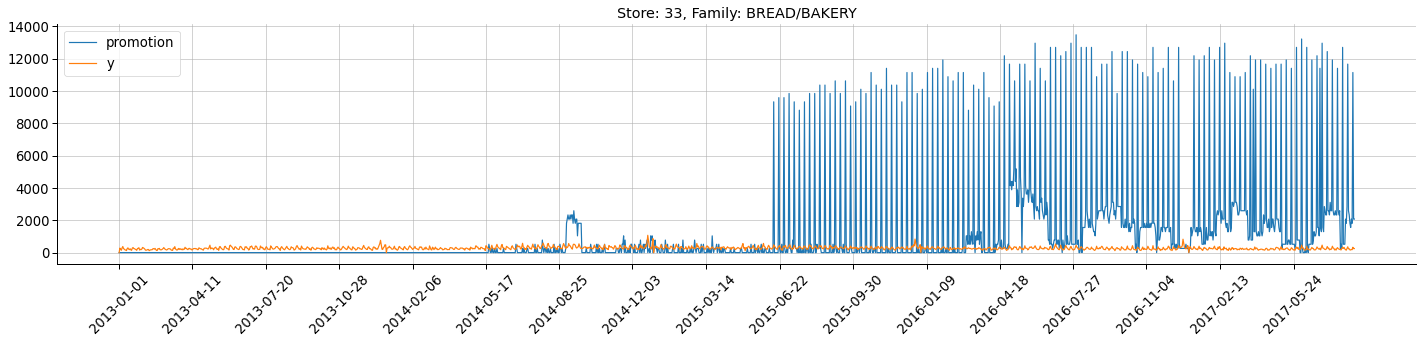

In [11]:
key = random.choice(list(unique_keys_test))
plot_ts(key)

In [12]:
train_df, test_df = data_di['train'], data_di['test']

train_df = train_df.assign(last_year_ds = train_df.ds - timedelta(days=52*7))
train_df = pd.merge(train_df, 
                         train_df[['ds', 'store_nbr', 'family', 'y']], 
                         left_on=['last_year_ds', 'store_nbr', 'family'], 
                         right_on=['ds', 'store_nbr', 'family']).rename(columns={'ds_x': 'ds', 'y_x': 'y', 'y_y': 'yhat'})

# Cross validation
val_df = train_df[(train_df.ds >= '2017-08-01') & (train_df.ds <= '2017-08-15')]
print('RMSLE: %s' %rmsle(val_df.yhat, val_df.y))

RMSLE: 0.9495


In [13]:
def plot_multi_ts(df, feature, n_cols=6, run_forecast=False, ds_range=None, periods=None, days_to_plot=None, path_save_fig= ""):
    
    group_by_store_df = df.groupby(['ds'] + [feature]).agg({'y': 'sum'}).reset_index()
    stores = list(set(group_by_store_df[feature]))
    n_rows = int(len(stores)/n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(40, 50))
    
    k = 0
    forecasts = []
    for i in tqdm(range(n_rows)):
        for j in range(n_cols):
            ts = group_by_store_df[group_by_store_df[feature] == stores[k]]
            
            if run_forecast:
                warnings.filterwarnings("ignore")
                df = ts[['ds', 'y']]
                df = df[(df.ds >= ds_range[0]) & (df.ds <= ds_range[1])]
        
                with suppress_stdout_stderr():
                    m = Prophet()
                    m.fit(df)
                    future = m.make_future_dataframe(periods=periods)
                    forecast = m.predict(future)
                
                kwargs = {feature: lambda x: stores[k]}
                forecast = forecast.assign(**kwargs).rename(columns={'yhat': 'yhat_'  + feature})
                forecasts.append(forecast)
                sns.set_context("paper", font_scale= 1)
                ax[i][j].plot(ts[-days_to_plot:].ds, ts[-days_to_plot:].y)
                ax[i][j].plot(forecast.iloc[-periods:].ds, forecast.iloc[-periods:]['yhat_'  + feature])
                labels = ['2017-05', '2017-09']
                ax[i][j].set_xticks(['2017-05', '2017-09'])
                ax[i][j].set_xticklabels(labels, rotation=45, ha='right')
                #plt.savefig(path_save_fig)
            else:
                ax[i][j].plot(ts.ds, ts.y)
                plt.savefig(path_save_fig)
            
            ax[i][j].set_title(feature + ": " + str(stores[k]), size=16)
            k += 1
    
    if run_forecast:
        forecast_per_feature = pd.concat(forecasts, axis=0)
        forecast_per_feature = pd.merge(group_by_store_df.rename(columns={'y': 'y_' + feature}), forecast_per_feature[['ds', 'yhat_' + feature] + [feature]], on=['ds'] + [feature], how='left')
    
        return forecast_per_feature

In [14]:
# plot_multi_ts(data_di['train'], 'store_nbr', run_forecast= False, path_save_fig= "../plots/eda_stores.pdf")

  0%|                                                                                                                                                                 | 0/9 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 11%|█████████████████                                                                                                                                        | 1/9 [00:07<01:03,  7.92s/it]INFO:prophet:Disabling d

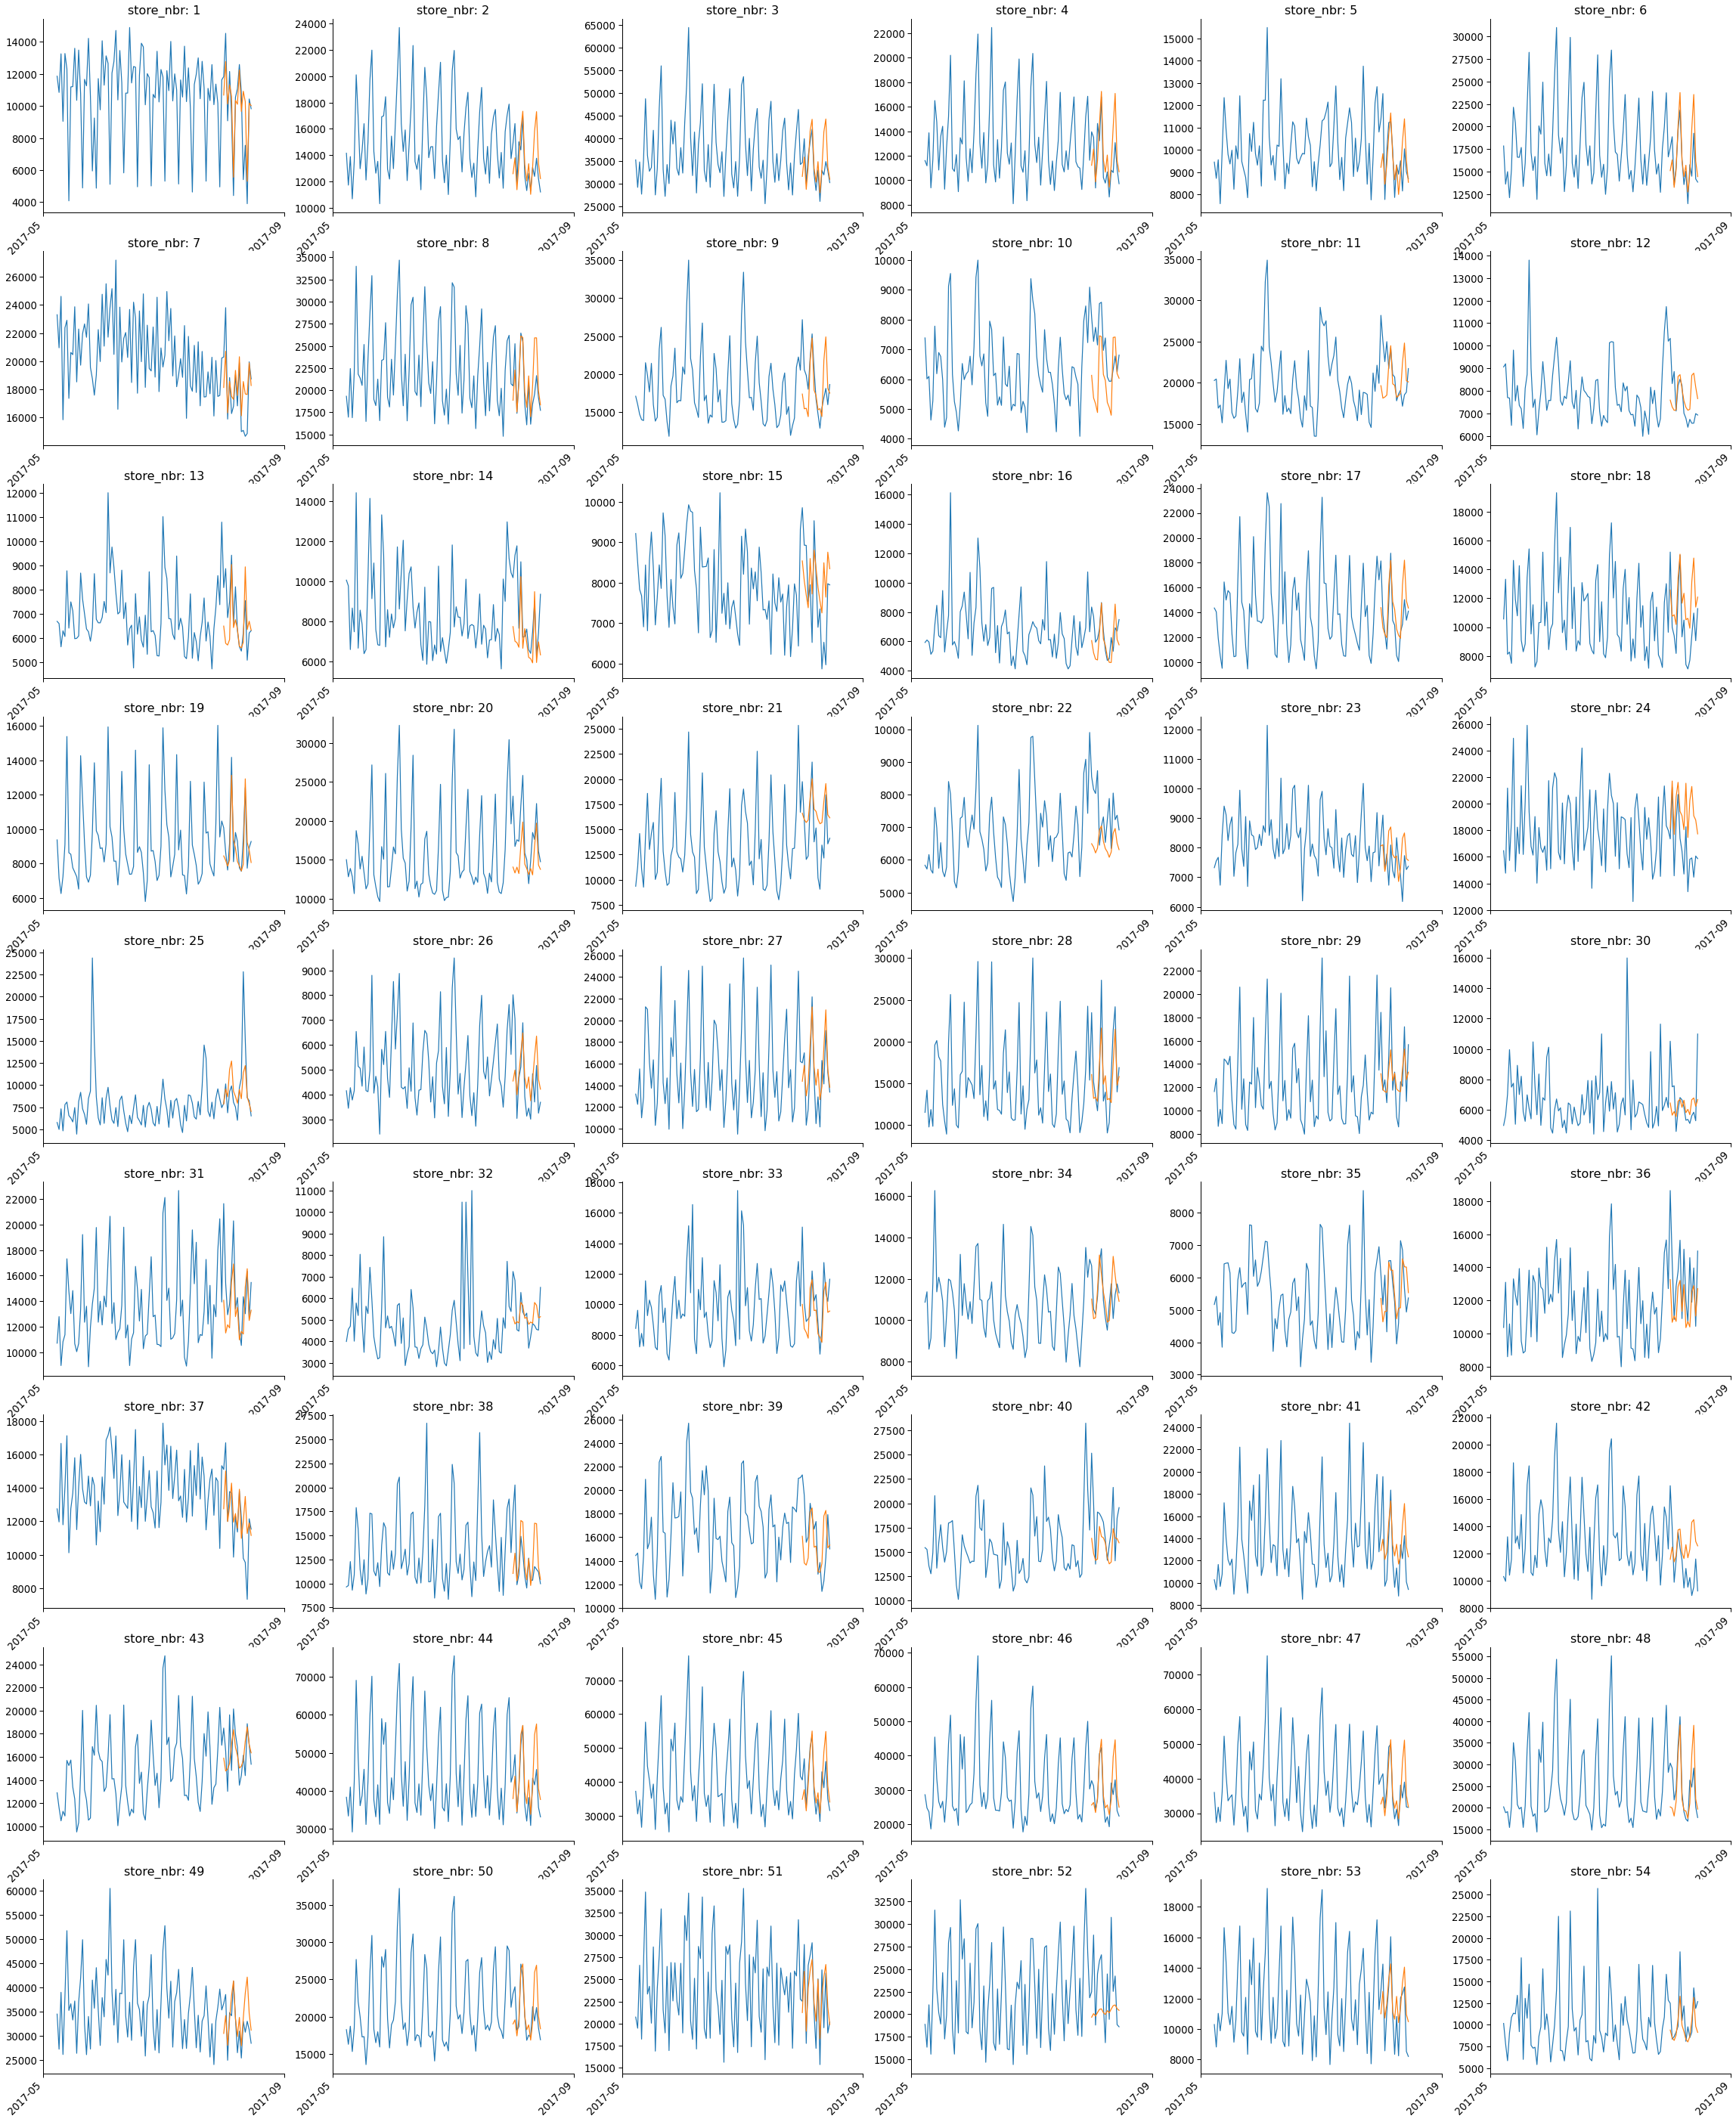

In [15]:
# Training period
ds_range = ['2013-01-01', '2017-07-31']
periods = 15
days_to_plot = 100

forecast_per_store = plot_multi_ts(data_di['train'], 'store_nbr', run_forecast=True, ds_range=ds_range, periods=periods, days_to_plot=days_to_plot, 
                                   path_save_fig= "../plots/forecast_store.pdf")

CPU times: user 1min 43s, sys: 1.48 s, total: 1min 44s
Wall time: 1min 44s


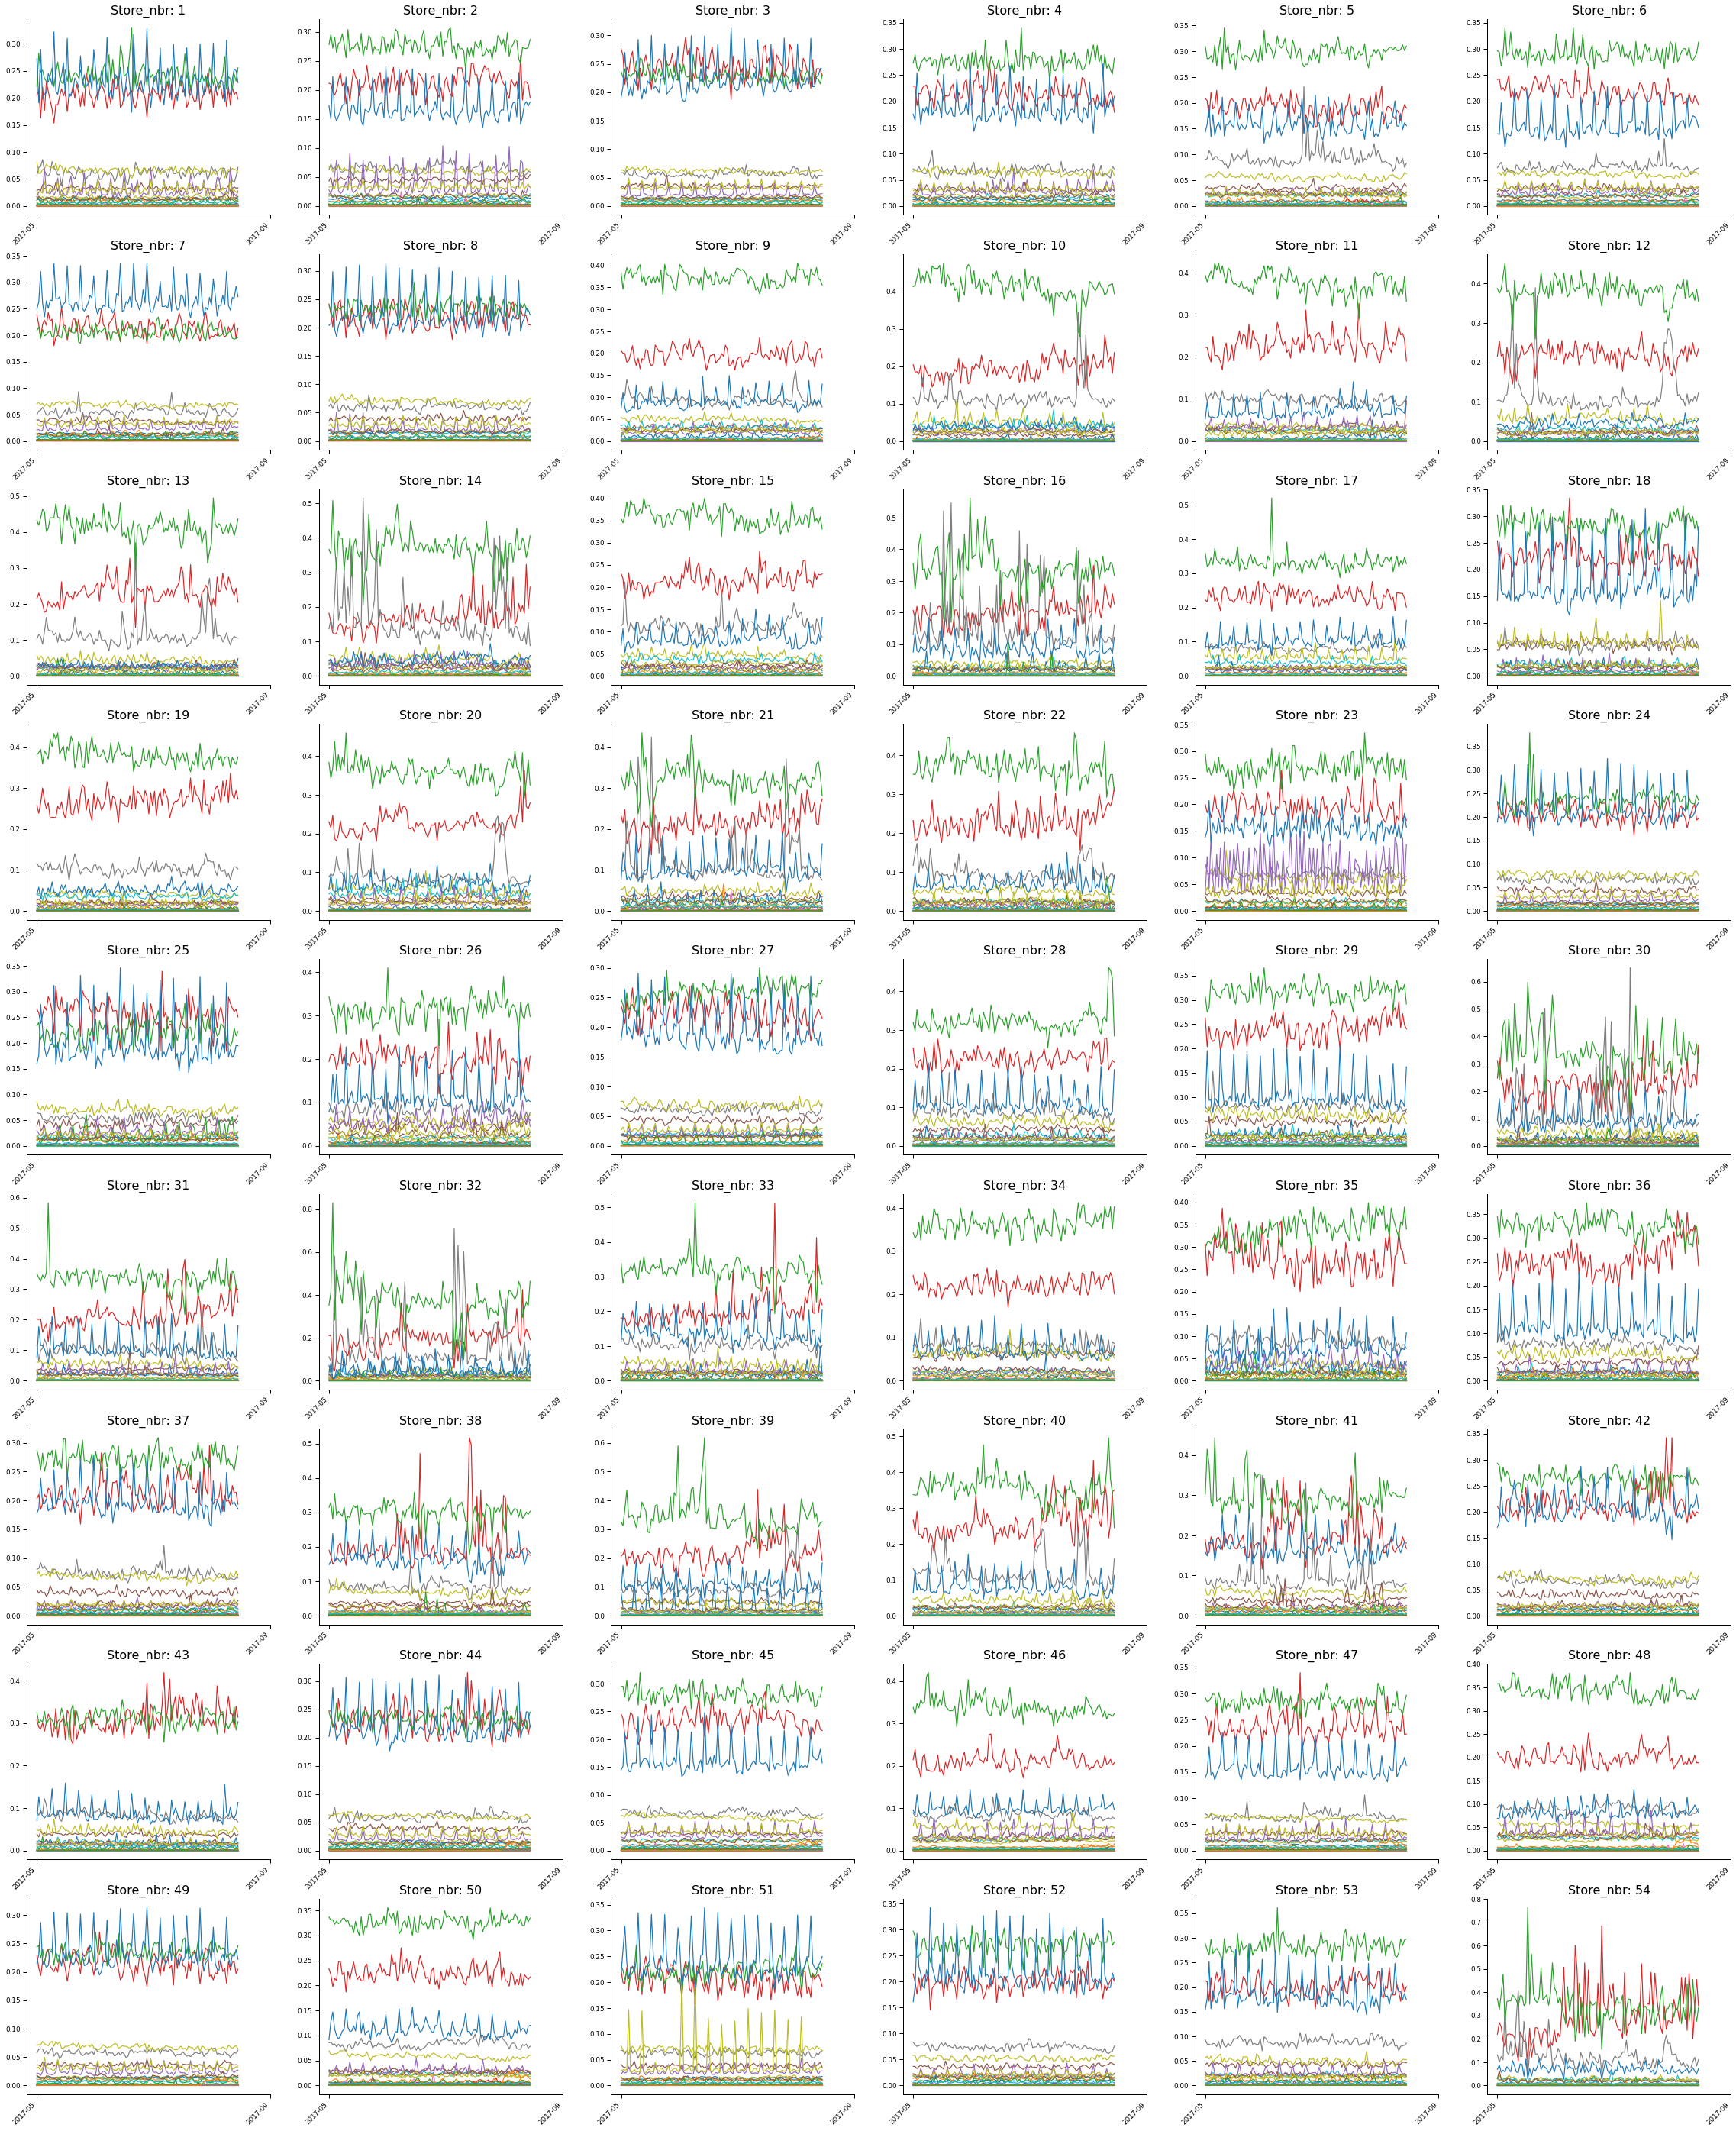

In [21]:
%%time
sns.set_context("paper", font_scale= 1)
path_save_fig = "../plots/forecast-store-family.pdf"

df = data_di['train']
df = pd.merge(df, forecast_per_store, on=['ds', 'store_nbr'], how='left')
df = df.assign(prop_family_per_store= df.y/df.y_store_nbr).fillna(0)

group_by_store_df = df.groupby(['ds'] + ['store_nbr']).agg({'y': 'sum'}).reset_index()
stores = list(set(group_by_store_df.store_nbr))
n_cols = 6
n_rows = int(len(stores)/n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(40, 50))

k = 0
for i in range(n_rows):
    for j in range(n_cols):
        sub_df = df[df.store_nbr == stores[k]]
        sub_df = sub_df[sub_df.ds >= '2017-05-01']
        for f in df.family.unique():
            ts = sub_df[sub_df.family == f]
            ax[i][j].plot(ts.ds, ts.prop_family_per_store)
            ax[i][j].set_title("Store_nbr: " + str(stores[k]), size=16)
            labels = ['2017-05', '2017-09']
            ax[i][j].set_xticks(['2017-05', '2017-09'])
            ax[i][j].set_xticklabels(labels, rotation=45, ha='right')
        plt.savefig(path_save_fig)
        k += 1

In [17]:
def get_last_available_week(df):
    # Get date of the last available week
    df = df.assign(diff_from_max_train_ds=df.ds - datetime.strptime(ds_range[1], "%Y-%m-%d"))
    df = df.assign(nb_weeks=np.ceil(df.diff_from_max_train_ds.dt.days/7).astype('int'))
    df = df.assign(last_week_ds=df.ds - (df.nb_weeks*7).map(lambda x: timedelta(x)))
    
    return df

def get_yhat(df):
    df = pd.merge(df, 
    df[['ds', 'store_nbr', 'family', 'prop_family_per_store']].rename(columns={'prop_family_per_store': 'last_week_prop_family_per_store'}),
         left_on = ['last_week_ds', 'store_nbr', 'family'],
         right_on=['ds', 'store_nbr', 'family'],
         how='left'
        ).drop(['diff_from_max_train_ds', 'nb_weeks', 'last_week_ds', 'ds_y'], axis=1).rename(columns={'ds_x': 'ds'})

    df = df.assign(yhat=df.yhat_store_nbr * df.last_week_prop_family_per_store)
    
    return df

df = get_last_available_week(df)
df.head()

id         ds  store_nbr      family      y  onpromotion  y_store_nbr  \
0   0 2013-01-01          1  AUTOMOTIVE 0.0000            0       0.0000   
1   1 2013-01-01          1   BABY CARE 0.0000            0       0.0000   
2   2 2013-01-01          1      BEAUTY 0.0000            0       0.0000   
3   3 2013-01-01          1   BEVERAGES 0.0000            0       0.0000   
4   4 2013-01-01          1       BOOKS 0.0000            0       0.0000   

   yhat_store_nbr  prop_family_per_store diff_from_max_train_ds  nb_weeks  \
0      5,265.5567                 0.0000             -1672 days      -238   
1      5,265.5567                 0.0000             -1672 days      -238   
2      5,265.5567                 0.0000             -1672 days      -238   
3      5,265.5567                 0.0000             -1672 days      -238   
4      5,265.5567                 0.0000             -1672 days      -238   

  last_week_ds  
0   2017-07-25  
1   2017-07-25  
2   2017-07-25  
3   2017-07-25  
4   2017-07-25

In [18]:
df = get_yhat(df)
df.head(2)

id         ds  store_nbr      family      y  onpromotion  y_store_nbr  \
0   0 2013-01-01          1  AUTOMOTIVE 0.0000            0       0.0000   
1   1 2013-01-01          1   BABY CARE 0.0000            0       0.0000   

   yhat_store_nbr  prop_family_per_store  last_week_prop_family_per_store  \
0      5,265.5567                 0.0000                           0.0010   
1      5,265.5567                 0.0000                           0.0000   

    yhat  
0 5.0976  
1 0.0000

In [19]:
rmsle( df[(df.ds > ds_range[1])].yhat, df[(df.ds > ds_range[1])].y )

0.6102